# Pilot - Running Analysis

This Jupyter Notebook is to quickly test feasibility of the things I want to do with this project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from butterworth_distance import get_data#, smooth, distance
from scipy import stats
import seaborn
seaborn.set()

In [2]:
def distance(data): # returns distance in m
#    d = d
    nextdata = pd.DataFrame([data['lat'].values, data['lon'].values, data['time'].values], ["nextlat", "nextlon","nexttime"])
    nextdata = nextdata.transpose().shift(periods=-1, axis=0)
    data = pd.concat([data, nextdata], axis=1)
    data['time'] = pd.to_datetime(data['time'])
    data['nexttime'] = pd.to_datetime(data['nexttime'])
    data['timediff'] = data['nexttime'] - data['time']
    
    radius=6371000
    lat = radify(data['lat']).astype(np.float64)
    lon = radify(data['lon']).astype(np.float64)
    nextlat = radify(data['nextlat']).astype(np.float64)
    nextlon = radify(data['nextlon']).astype(np.float64)
    
    a = 2*radius
    b = (np.sin((nextlat-lat)/2))**2
    c = np.cos(lat) * np.cos(nextlat) * ((nextlon-lon)/2)**2

    data['distbetween'] = a*np.arcsin(np.sqrt(b+c))
    
    # Want to exclude any pauses (gaps in GPS data longer than 8 seconds)
    # and any slow running (pace greater than 0.67 s/m, same as speed
    # less than 1.5 m/s)
    data['pace'] = data['timediff'] / data['distbetween']
    
    maximumtime = pd.Timedelta(seconds=8)
    maximumpace = pd.Timedelta(seconds=0.67)

    selecteddata = data[(data['timediff'] <= maximumtime) | (data['pace'] <= maximumpace)]
    
    totaldistance = pd.DataFrame.sum(selecteddata['distbetween'], axis=0)
    return totaldistance

def radify(column):
    return column * np.pi / 180
    
def get_distance(filename, bool):
    points = get_data(filename)
    if bool:
        latlon = pd.DataFrame([points['lat'], points['lon']]).transpose()
        pointsre = smooth(latlon)
        points.drop(labels=['lat', 'lon'], axis=1, inplace=True)
        points = pd.concat([points, pointsre], axis=1)
        res = distance(points)
        #print('Smoothing: %0.2f' % res)
    else:
        res = distance(points)
        #print('No smoothing: %0.2f' % res)
    return res

def smooth(data):
    # Return Butterworth-smoothed data
    from scipy import signal
    b, a = signal.butter(3, 0.3, btype='low', analog=False)
    lat = signal.filtfilt(b, a, data['lat'])
    lon = signal.filtfilt(b, a, data['lon'])
    low_passed = pd.DataFrame([lat, lon], ["lat", "lon"]).transpose()
    #low_passed = low_passed.transpose()
    return low_passed


get_distance('RK_gpx _2017-07-13_1747.gpx', True)
get_distance = np.vectorize(get_distance)

In [3]:
running_data = []
for filename in os.listdir(os.getcwd()):
    if (filename[-4::] == '.gpx'):
        running_data.append(filename)

In [4]:
running_df = pd.DataFrame(data=running_data, columns=['filename'])
running_df['datetime'] = running_df['filename'].str.slice(start=8, stop=23)

In [5]:
# strptime stuff

In [6]:
running_df['datetime'] = pd.to_datetime(running_df['datetime'], format='%Y-%m-%d_%H%M')
def to_timestamp(inputdatetime):
    return inputdatetime.timestamp()
running_df['timestamp'] = running_df['datetime'].apply(to_timestamp)

In [7]:
running_df['distance1'] = get_distance(running_df['filename'], True)
running_df['distance2'] = get_distance(running_df['filename'], False)

In [8]:
fit1 = stats.linregress(running_df['timestamp'], running_df['distance1'])
fit2 = stats.linregress(running_df['timestamp'], running_df['distance2'])

In [9]:
print('The p-value is', fit1.pvalue)
print('The p-value is', fit2.pvalue)

The p-value is 0.0304633956198
The p-value is 0.0134747311063


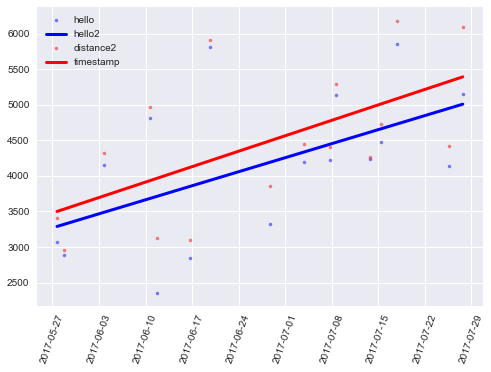

In [19]:
plt.figure()
plt.plot(running_df['datetime'], running_df['distance1'], 'b.', alpha = 0.5, label='hello')
plt.plot(running_df['datetime'], running_df['timestamp']*fit1.slope+fit1.intercept, 'b-', linewidth=3, label='hello2')
plt.plot(running_df['datetime'], running_df['distance2'], 'r.', alpha = 0.5)
plt.plot(running_df['datetime'], running_df['timestamp']*fit2.slope+fit2.intercept, 'r-', linewidth=3)
plt.xticks(rotation=70)
plt.legend()
plt.show()
#plt.figure()

#plt.xticks(rotation=70)
#plt.show()